In [ ]:
#@title
from IPython.display import HTML, display

title = "<h1 style='font-family:Comic Sans MS; font-size:50px; color:pink; text-shadow: 2px 2px #aaaaaa; text-align:center'>Natural Language Processing: Deep Learning Approach </h1>"
display(HTML(title))

## 🌸 Libraries

In [ ]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install negspacy
!{sys.executable} -m pip install spacy_stanza 

In [ ]:
!pip install wandb

In [52]:
#Needed libraries

from torch.utils.data import Dataset
from torchtext.vocab import Vocab
from collections import Counter
import matplotlib.pyplot as plt

import numpy as np
import json

import wandb

import spacy # to build a nlp pipeline
import stanza # for named entity recognition
import spacy_stanza

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchtext

import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

## 🌸 Dataset class

A large dataset is created using the texts and annotations from the json file. Every text is tokenized and assigned its corresponding label (NEG, UNC, NSCO, USCO or O).

In [3]:
class using_words (Dataset):

    def __init__(self, data, texts_to_process = 5, start = 0):

        self.word_tokenized_data = []
        self.labels = []
        self.vocab = []
        self.label_vocab = []

        processed_texts = 0 

        nlp = spacy_stanza.load_pipeline('es') #Loading a Spacy-Stanza pipeline for the Spanish language

        for i in range(start, start+texts_to_process):

            text = data[i]["data"]["text"] #Iterating for all texts in json file
            label = list(np.full(len(text), "O", dtype=str))

            #Creating labels for each char

            for value in data[i]["predictions"][0]["result"]:

                if value["value"]["labels"][0]== "NEG":

                    start = value["value"]["start"]
                    end = value["value"]["end"]

                    #print(text[start:end])
                    label[start:end] = ["NEG"] * (end - start)
                    #print(labels[start:end-1])
                
                elif value["value"]["labels"][0]== "UNC":

                    start = value["value"]["start"]
                    end = value["value"]["end"]

                    #print(text[start:end])
                    label[start:end] = ["UNC"] * (end - start)
                    #print(labels[start:end-1])

                elif value["value"]["labels"][0]== "USCO":

                    start = value["value"]["start"]
                    end = value["value"]["end"]

                    #print(text[start:end])
                    label[start:end] = ["USCO"] * (end - start)
                    #print(labels[start:end-1])
                
                elif value["value"]["labels"][0]== "NSCO":

                    start = value["value"]["start"]
                    end = value["value"]["end"]

                    #print(text[start:end])
                    label[start:end] = ["NSCO"] * (end - start)
                    #print(labels[start:end-1])

            
            #Text tokenization

            doc = nlp(text)

            #Update the labels for every token

            i = 0

            self.word_tokenized_data.append("<start>")
            self.labels.append("O")

            #print(self.word_tokenized_data)

            for token in doc:

                while text[i] == " ":  #IMPORTANT to handle spaces
                    i+=1

                token_label = label[i]  # Get the label for the current token

                self.word_tokenized_data.append(token.text)
                self.labels.append(token_label)

                i += len(token)

            self.word_tokenized_data.append("<end>")
            self.labels.append("O")

            processed_texts += 1  # Increment the counter

            if processed_texts == texts_to_process:  # Stop processing after 5 texts
                break

    def build_vocab(self):
        tokens = self.word_tokenized_data
        word_counts = Counter(tokens)
        self.vocab = list(word_counts.keys())
        self.vocab.append("<unk>")

        labels = self.labels
        label_counts = Counter(labels)
        self.label_vocab = list(label_counts.keys())
    
    def word_to_index(self, word):
       # return self.vocab.index(word) if word in self.vocab else self.vocab.index("<unk>")
        return self.vocab.index(word) if word in self.vocab else self.vocab.index("<unk>")
    
    def index_to_word(self, index):
        return self.vocab[index]

    def label_to_index(self, label):
        return self.label_vocab.index(label)

    def index_to_label(self, index):
        return self.label_vocab[index]

    def __len__(self):
        return len(self.word_tokenized_data)

    def __getitem__(self, index):
        tokenized_sentence = self.word_tokenized_data[index]
        label = self.labels[index]

        return tokenized_sentence, label


## 🌸  Loading data

In [4]:
with open("negacio_uab_revised_version.json", "r", encoding="utf-8") as f:
    data = json.load(f)

## 🌸  Generating dataset

The code below created a dataset if it has not been created. However, if it already exists it loads it.

In [ ]:
preprocessed_file = "train_dataset.pkl"

if os.path.exists(preprocessed_file):
    # Load the preprocessed dataset from the file
    with open(preprocessed_file, "rb") as file:
        dataset = pickle.load(file)
else:
    # Preprocess the dataset
    dataset = using_words(data,texts_to_process = 223, start = 0)
    dataset.build_vocab()

    # Save the preprocessed dataset to a file
    with open(preprocessed_file, "wb") as file:
        pickle.dump(dataset, file)

In [ ]:
preprocessed_file = "val_dataset.pkl"

if os.path.exists(preprocessed_file):
    # Load the preprocessed dataset from the file
    with open(preprocessed_file, "rb") as file:
        dataset_val = pickle.load(file)
else:
    # Preprocess the dataset
    dataset_val = using_words(data,texts_to_process = 90, start = 223)
    dataset_val.build_vocab()

    # Save the preprocessed dataset to a file
    with open(preprocessed_file, "wb") as file:
        pickle.dump(dataset, file)

## 🌸  Dataloader

In [67]:
# Define the batch size for training and validation
batch_size = 64

# Create the data loaders for training and validation
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False) #Shuffle false, order is important
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False) 


Check it was correctly created:

In [10]:
# Iterate over one batch
for batch_inputs, batch_labels in train_dataloader:
    # Print the batch inputs and labels
    print("Batch Inputs:")
    print(batch_inputs)
    print("Batch Labels:")
    print(batch_labels)
    break # Break after printing the first batch

Batch Inputs:
('<start>', 'nº', 'historia', 'clinica', ':', '**', '***', '***', 'nºepisodi', ':', '********', 'sexe', ':', 'dona', 'data', 'de', 'naixement', ':', '06.06.1938', 'edat', ':', '79', 'anys', 'procedencia', 'domicil/res', '.soc', 'servei', 'psiquiatria', 'data', "d'ingres", '10.05.2018', 'data', "d'alta", '10.05.2018', '16:46:41', 'ates', 'per', '****************', ',', '************', ';', '*************', ',', 'assumpta', 'informe', "d'alta", "d'hospitalitzacio", 'motiu', "d'ingres", 'paciente', 'de', '79', 'años', 'que', 'acude', 'derivada', 'a', 'urgencias', 'de', 'psiquiatria', 'tras', 'sim', '.', 'antecedents')
Batch Labels:
('O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O')


Should be same size:

In [11]:
len(dataset.word_tokenized_data)

9664

In [12]:
len(dataset.labels)

9664

## 🌸  Negation Detection Model

In [13]:
class NegationDetectionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):

        super(NegationDetectionModel, self).__init__()
        #Change whatever you want here
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, inputs):

        embedded = self.embedding(inputs)
        outputs, _ = self.rnn(embedded)
        logits = self.fc(outputs)
        probabilities = self.softmax(logits)
        return probabilities

In [68]:
#Change whatever you want here

vocab_size = len(dataset.vocab)
embedding_dim = 100  
hidden_dim = 150
num_classes = 5  # NEG, UNC, NSCO, USCO, and O.

model = NegationDetectionModel(vocab_size, embedding_dim, hidden_dim, num_classes)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust the learning rate if needed


Labels and words to indices, preparing them to be passed to the model.

In [16]:
batch_inputs_indices = []
batch_labels_indices =  []

for batch_inputs, batch_labels in train_dataloader:

  for token in batch_inputs:
    batch_inputs_indices.append(dataset.word_to_index(token))

  for label in batch_labels:
    batch_labels_indices.append(dataset.label_to_index(label))

In [17]:
print(batch_inputs_indices)
print(batch_labels_indices)

[0, 1, 2, 3, 4, 5, 6, 6, 7, 4, 8, 9, 4, 10, 11, 12, 13, 4, 14, 15, 4, 16, 17, 18, 19, 20, 21, 22, 11, 23, 24, 11, 25, 24, 26, 27, 28, 29, 30, 31, 32, 33, 30, 34, 35, 25, 36, 37, 23, 38, 12, 16, 39, 40, 41, 42, 43, 44, 12, 22, 45, 46, 47, 48, 49, 50, 51, 52, 53, 49, 54, 55, 56, 57, 58, 59, 60, 61, 47, 49, 62, 56, 57, 63, 47, 49, 64, 65, 66, 12, 67, 68, 69, 56, 57, 59, 70, 71, 72, 47, 73, 74, 75, 59, 76, 12, 77, 78, 56, 79, 80, 43, 81, 12, 82, 83, 84, 85, 30, 59, 86, 12, 87, 30, 88, 30, 89, 90, 43, 91, 85, 71, 91, 83, 92, 93, 94, 47, 95, 96, 43, 97, 98, 99, 100, 101, 57, 63, 59, 102, 103, 104, 47, 105, 35, 12, 79, 106, 12, 97, 12, 107, 12, 108, 109, 110, 95, 12, 106, 111, 43, 112, 113, 12, 79, 114, 66, 115, 59, 57, 43, 79, 106, 12, 72, 116, 117, 118, 30, 71, 95, 119, 43, 120, 121, 122, 47, 123, 56, 124, 12, 125, 121, 126, 127, 128, 70, 30, 129, 30, 130, 131, 43, 132, 47, 133, 4, 134, 30, 50, 135, 47, 136, 137, 138, 59, 79, 40, 136, 139, 56, 140, 47, 141, 56, 142, 143, 144, 145, 47, 146, 

## 🌸  Training

In [65]:
num_epochs = 25

We will track every run, so we can use Weights and Biases platform for generating plots and distinguish the best parameters for the model.

In [73]:
wandb.login()

True

In [ ]:
wandb.init(project="natural_language", entity = "juliagartor")

# Log the hyperparameters
config = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
}
wandb.config.update(config)

In [ ]:
for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0

    for batch_inputs, batch_labels in train_dataloader:

        batch_inputs_indices.clear()
        batch_labels_indices.clear()

        for token in batch_inputs:
          batch_inputs_indices.append(dataset.word_to_index(token))

        for label in batch_labels:
            batch_labels_indices.append(dataset.label_to_index(label))
        
        #print(batch_inputs_indices)
        #print(batch_labels_indices)

        # Convert batch inputs and labels to tensors
        batch_inputs_tensor = torch.tensor(batch_inputs_indices)
        batch_labels_tensor = torch.tensor(batch_labels_indices)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_inputs_tensor)

        # Compute the loss
        loss = criterion(outputs, batch_labels_tensor)

        # Backward pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Calculate the average loss for the epoch
    average_loss = running_loss / len(train_dataloader)

    # Log the loss for the current epoch
    wandb.log({"Loss": average_loss})

    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")


- Evaluation

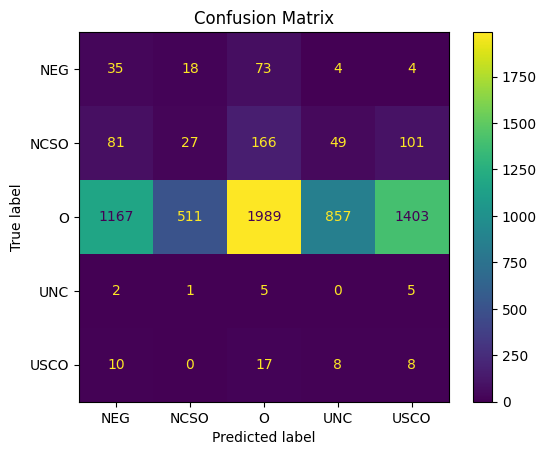

Accuracy: 31.48%
Classification Report:
              precision    recall  f1-score   support

         NEG       0.03      0.26      0.05       134
        NSCO       0.05      0.06      0.06       424
           O       0.88      0.34      0.49      5927
         UNC       0.00      0.00      0.00        13
        USCO       0.01      0.19      0.01        43

    accuracy                           0.31      6541
   macro avg       0.19      0.17      0.12      6541
weighted avg       0.80      0.31      0.45      6541



In [64]:
wandb.init(project="natural_language", entity = "juliagartor")

model.eval()  # Set the model to evaluation mode

all_val_labels = []
all_predicted_labels = []

for val_inputs, val_labels in val_dataloader:
    batch_inputs_indices.clear()
    batch_labels_indices.clear()

    for token in val_inputs:
        batch_inputs_indices.append(dataset.word_to_index(token))

    for label in val_labels:
        batch_labels_indices.append(dataset.label_to_index(label))

    # Convert batch inputs to a tensor
    batch_inputs_tensor = torch.tensor(batch_inputs_indices)

    # Forward pass
    outputs = model(batch_inputs_tensor)

    # Get the predicted labels
    _, predicted_indices = torch.max(outputs, 1)

    # Convert predicted indices to label format
    predicted_labels = [dataset.index_to_label(index) for index in predicted_indices]

    # Accumulate the labels and predictions
    all_val_labels.extend(val_labels)
    all_predicted_labels.extend(predicted_labels)

# Convert labels to numpy arrays
val_labels_array = np.array(all_val_labels)
predicted_labels_array = np.array(all_predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(val_labels_array, predicted_labels_array)

# Calculate accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)

wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(y_true=val_labels_array, preds=predicted_labels_array),
           "Accuracy": accuracy})

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEG","NCSO","O","UNC","USCO"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Print accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Print classification report
print("Classification Report:")
print(classification_report(val_labels_array, predicted_labels_array,zero_division=0))

In [76]:
wandb.finish()

In [49]:
# Preprocess the text
preprocessed_text = """
informe d'epicrisi motiu d'ingres mujer de 94 años de edad que ingresa desde urgencias por hematuria anemizante. antecedents 
-sin alergias medicamentosas conocidas - hipertension arterial. - fibrilacion auricular de larga evolucion en tratamiento anticoagulante con dabigatran. 
- cardiopatia isquemica en forma de angor de esfuerzo de largo tiempo de evolucion. - carcinoma ductal infiltrante de mama izquierda por lo que se realizo mastectomia 
con limfadenectomia en 2001. actualmente libre de enfermedad. -multiples episodios de celulitis en la extremidad superior izquierda como consecuencia de linfedema. -
hemotorax izquierdo en contexto de caida y fractura costal izquierda en febrero de 2016. -anemia ferropenica. -hiperreactividad bronquial. situacion sociofuncional: vive sola.
 independiente para actividades basicas e instrumentales de la vida diaria. no deterioro cognitivo. proces actual paciente portadora de sonda vesical por retencion aguda de orina 
 en contexto de hematuria que consulto en urgencias por obstruccion de la misma. se habia realizado una ecografia urinaria que no informaba de hallazgos destacables y se encontraba 
 pendiente de realizacion de una cistoscopia para completar el estudio. se coloco una sonda tiemnann 20 ch para realizar una lavado vesical manual obteniendo abundantes coagulos, 
 se dejo una sonda de tres vias para lavado vesical continuo y se dejo a la paciente en observacion. durante su estancia en urgencias persistio la hematuria y presento una anemizacion 
 progresiva hasta una hemoglobina de 7 g/dl que requirio una transfusion de 2 concentrados de hematies. se decidio realziar un tc abdominal urgente que informaba de la existencia de un
 
  """

# Convert the preprocessed text into a tensor format
text_indices = [dataset.word_to_index(token) for token in preprocessed_text]
text_tensor = torch.tensor(text_indices)

# Set the model to evaluation mode
model.eval()

# Forward pass
output = model(text_tensor.unsqueeze(0))  # Add an extra dimension for batch size (assuming batch size of 1)

output_np = output.detach().numpy()
predicted = [output_np[0][i].argmax() for i in range(len(output_np[0]))]

# Convert the predicted indices to real labels
predicted_labels = [dataset.index_to_label(index) for index in predicted]

# Print the real labels
print("Real Labels:")
print(predicted_labels)

Real Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '